In [555]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pymaid
import logging
import random
from graspologic.match import graph_match
from graspologic.simulations import er_np
from graspologic.utils import is_unweighted
from numpy.random import default_rng
from pkg.platy import _get_folder, load_connectome_normal_lcc_annotations_v2, load_connectome_normal_lcc_annotations_v3, load_connectome_lcc_normal_adj, load_left_adj, load_right_adj, load_left_adj_labels_with_class_v2, load_right_adj_labels_with_class_v2, load_head_adj_labels_with_class_v2, load_pygidium_adj_labels_with_class_v2, load_0_adj, load_1_adj_labels_with_class_v2, load_2_adj_labels_with_class_v2, load_3_adj_labels_with_class_v2, load_left_adj_labels_with_class_v3, load_right_adj_labels_with_class_v3

In [569]:
folder = _get_folder()

rm = pymaid.CatmaidInstance(
    server="https://catmaid.jekelylab.ex.ac.uk/#",
    project_id=11,
    api_token=None,
    http_user=None,
    http_password=None,
)
logging.getLogger("pymaid").setLevel(logging.WARNING)
pymaid.clear_cache()

Grab Nadine's pairs: these are the true pairs

In [557]:
folder = "/Users/kareefullah/Desktop/naomi-pairwise.xlsx"
true_df = pd.read_excel(folder, dtype=str)

#need to subset true_pairs for the pairs that have left and right entries in their row
true_pairs = true_df[["skid-ID LEFT", "skid-ID RIGHT"]]

#subset true_pairs to not include pairs of neurons that do not have a match
true_pairs = true_pairs[~true_pairs.isnull().any(axis=1)].reset_index()
left_true = list(true_pairs["skid-ID LEFT"])
right_true = list(true_pairs["skid-ID RIGHT"])
true_pairs

,index,skid-ID LEFT,skid-ID RIGHT
0,0,7501,25010
1,1,10536,26163
2,2,6743,23921
3,3,151847,27064
4,4,12115,27917
...,...,...,...
288,669,1326008,1359694
289,670,1717565,1330831
290,671,493317,1299058
291,672,1855933,111948


Load in the left and right adjacency matrices (each neuron in both adjacencies has an associated class label)

In [558]:
left_adj, left_labels = load_left_adj_labels_with_class_v3()
right_adj, right_labels = load_right_adj_labels_with_class_v3()

np_left_adj = np.array(left_adj)
np_right_adj = np.array(right_adj)

np_left_labels = np.array(left_labels)
np_right_labels = np.array(right_labels)

left_skids = np.array(left_adj.index)
right_skids = np.array(right_adj.index)

print(len(left_adj))
print(len(right_adj))

967
919


In [559]:
sub_left_skids = [skid for skid in left_skids if skid in left_true]
sub_right_skids = [skid for skid in right_skids if skid in right_true]

sub_left_skids = np.array(sub_left_skids)
sub_right_skids = np.array(sub_right_skids)

#find the inds from left and right skid lists that are in the respective subgraphs
left_inds = [i for i, e in enumerate(left_skids) if e in sub_left_skids]
right_inds = [i for i, e in enumerate(right_skids) if e in sub_right_skids]

#grab the subset of labels from the ind lists
sub_left_labels = np_left_labels[left_inds]
sub_right_labels = np_left_labels[right_inds]

We begin by initializing the whole/sub adjacencies by permuting the skids based on whether the skids are in Nadine's list or not

In [560]:
#the correct function that initializes the skids and adjs, don't need to make lists because the skids are dropped during graph matching, and in the cases that 
#we don't run graph matching we randomize the unpaired skids multiple times and drop the last few to make the dimensions match
def init_skids_and_adjs_v2(type="whole"):
    """
    This function modifies the left and right skid lists such that the skids that are paired in Nadine's lists are moved to the front of their
    respective lists and aligned, while the other skids moved after these skids. We also permute the neurons' respective labels accordingly.
    After constructing these permuted skid lists, we extract adjacencies from them.

    Args:
        type: (str, optional): 
            "whole": use the whole skid lists and labels.
            "sub": use the sub skid lists and labels. 
            Defaults to "whole".

    
    Returns:
        values: (dict):
            "left_adj": the initialized left adj.
            "right_adj": the initialized right adj.
            "left_skids_in_pairs": the left skids that are paired in Nadine's lists
            "left_skids_to_match": the initialized list of left skids.
            "right_skids_to_match": the initialized list of right skids.
            "num_pairs": the number of pairs in our skid lists that existed in Nadine's list.
            "left_labels_perm_list": the permuted list of left labels.
            "right_labels_perm_list": the permuted list of right labels.
            "class_sim_mat": the class similarity matrix constructed from the left and right labels.
    """

    if(type=="whole"):

        #the original skid lists
        left_skids_to_use = left_skids.copy()
        right_skids_to_use = right_skids.copy()

        #the original labels
        left_labels_to_use = np_left_labels.copy()
        right_labels_to_use = np_right_labels.copy()

    elif(type=="sub"):
        left_skids_to_use = sub_left_skids.copy()
        right_skids_to_use = sub_right_skids.copy()

        left_labels_to_use = sub_left_labels.copy()
        right_labels_to_use = sub_right_labels.copy()

    else:
        return
    
    #these are the lists of the skids that are paired in Nadine's lists, and both of the skids in the pair exist in our left and right lists respectively
    left_skids_in_pairs = []
    right_skids_in_pairs = []

    #need to save the indices where in which the skids of the original lists are permuted so we can permute the labels respectively
    left_inds_pairs_permuted = []
    right_inds_pairs_permuted = []

    #iterate through Nadine's list
    for i in range(len(true_pairs)):

        #find the pairs in Nadine's lists in which both neurons are in our left and right lists respectively
        if (true_pairs.loc[i, "skid-ID LEFT"] in left_skids_to_use and true_pairs.loc[i, "skid-ID RIGHT"] in right_skids_to_use):
            left_skids_in_pairs.append(true_pairs.loc[i, "skid-ID LEFT"])
            right_skids_in_pairs.append(true_pairs.loc[i, "skid-ID RIGHT"])

            #find the inds in our left and right skids lists where these neurons in Nadine's pair exist, need the inds to permute our labels
            left_ind = np.where(left_skids_to_use == true_pairs.loc[i, "skid-ID LEFT"])[0][0]
            right_ind = np.where(right_skids_to_use == true_pairs.loc[i, "skid-ID RIGHT"])[0][0]
            left_inds_pairs_permuted.append(left_ind)
            right_inds_pairs_permuted.append(right_ind)

    #num_pairs is the length of either the left or right skids in pairs list
    num_pairs = len(left_skids_in_pairs)

    #get the list of skids in our left and right skids that are not in the lists we just made and shuffle them:
    rng = default_rng()

    left_skids_not_pairs = []
    left_inds_not_pairs = []
    for j in range(len(left_skids_to_use)):
        if(left_skids_to_use[j] not in left_skids_in_pairs):
            left_skids_not_pairs.append(left_skids_to_use[j])
            
            #get the ind where these non paired neurons occur
            left_ind = np.where(left_skids_to_use == left_skids_to_use[j])[0][0]
            left_inds_not_pairs.append(left_ind)

    #iterate through right skids 
    right_skids_not_pairs = []
    right_inds_not_pairs = []
    for j in range(len(right_skids_to_use)):
        if(right_skids_to_use[j] not in right_skids_in_pairs):
            right_skids_not_pairs.append(right_skids_to_use[j])
            
            #get the ind where these non paired neurons occur
            right_ind = np.where(right_skids_to_use == right_skids_to_use[j])[0][0]
            right_inds_not_pairs.append(right_ind)
        
    #shuffle the lists to introduce randomization of which left skids get discarded
    left_skids_not_pairs = np.array(left_skids_not_pairs)
    right_skids_not_pairs = np.array(right_skids_not_pairs)
    left_inds_not_pairs = np.array(left_inds_not_pairs)
    right_inds_not_pairs = np.array(right_inds_not_pairs)

    #randomize the skids
    rand_ind_left = rng.choice(len(left_skids_not_pairs), size=len(left_skids_not_pairs), replace=False)
    left_skids_not_pairs_rand = left_skids_not_pairs[rand_ind_left]

    #update the corresponding inds
    left_inds_not_pairs_rand = left_inds_not_pairs[rand_ind_left]

    #randomize the skids
    rand_ind_right = rng.choice(len(right_skids_not_pairs), size=len(right_skids_not_pairs), replace=False)
    right_skids_not_pairs_rand = right_skids_not_pairs[rand_ind_right]

    #update the corresponding inds
    right_inds_not_pairs_rand = right_inds_not_pairs[rand_ind_right]

    #make lists of left and right skids and inds through concatenating
    left_skids_to_match = np.append(left_skids_in_pairs, left_skids_not_pairs_rand, axis=0)
    right_skids_to_match = np.append(right_skids_in_pairs, right_skids_not_pairs_rand, axis=0)
    left_inds_permuted = np.append(left_inds_pairs_permuted, left_inds_not_pairs_rand, axis=0)
    right_inds_permuted = np.append(right_inds_pairs_permuted, right_inds_not_pairs_rand, axis=0)
        
    #permute the labels of the neurons based on how the skids were permuted
    right_labels_perm = right_labels_to_use[right_inds_permuted]
    left_labels_perm = left_labels_to_use[left_inds_permuted]

    #make class similarity matrix using the permuted labels
    class_sim_mat = []
    class_sim_mat = left_labels_perm[:, None] == right_labels_perm[None, :]

    left_adj_skids = list(left_skids_to_match)
    right_adj_skids = list(right_skids_to_match)

    #generate the adjs
    left_adj_induced = pymaid.adjacency_matrix(left_adj_skids)
    right_adj_induced = pymaid.adjacency_matrix(right_adj_skids)

    np_left_adj_induced = np.array(left_adj_induced)
    np_right_adj_induced = np.array(right_adj_induced)
        
    #return as dict
    values = dict()
    values["left_adj"] = np_left_adj_induced
    values["right_adj"] = np_right_adj_induced
    values["left_skids_in_pairs"] = left_skids_in_pairs
    values["left_skids_to_match"] = left_skids_to_match
    values["right_skids_to_match"] = right_skids_to_match
    values["num_pairs"] = num_pairs
    values["left_labels_perm"] = left_labels_perm
    values["right_labels_perm"] = right_labels_perm
    values["class_sim_mat"] = class_sim_mat
    #need the adj lists for every case, need the skids list for every case except when not running graph matching, need num_pairs for every case to calculate accuracy
    #need the labels list for incorporating class labels
    return values

In [561]:
#function that randomly deletes skids from the left skid list n_iters times so the dimensions between the left and right skids match
#returns the dataframe of the paired left right skids and the list of permuted left inds which is necessary to permute the left adj when calculating norm
#NOTE: only need for the cases where no graph matching occurs
def match_skid_dims(left_skids, right_skids, num_pairs, n_iters, rand_all=False):
    #beginning of ind list
    ind_left_paired = np.arange(num_pairs)

    ind_left_list = []
    ind_right_list = []
    paired_df_list = []
    rng = default_rng()
    for i in range(n_iters):
        
        #only randomize the non_paired
        if(not rand_all):
            #randomize the non paired skids to delete 
            rand_ind_left = rng.choice(len(left_skids[num_pairs:]), size=len(right_skids[num_pairs:]), replace=False)

            #have to add all the rand_ind_left by num_pairs so the indices correspond to all the unmatched neurons
            rand_ind_left_perm = [i+num_pairs for i in rand_ind_left]

            #updated inds and skids 
            left_skids_not_matched_perm = left_skids[rand_ind_left_perm]
            updated_left_skids_perm = np.append(left_skids[0:num_pairs], left_skids_not_matched_perm, axis=0)
            updated_right_skids_perm = right_skids
            updated_ind_left = np.append(ind_left_paired, rand_ind_left_perm, axis=0)
            updated_ind_right = np.arange(len(right_skids))
        
        #randomize the whole skid list for both left and right
        else:
            updated_ind_left = rng.choice(len(left_skids), size=len(right_skids), replace=False)
            updated_ind_right = rng.choice(len(right_skids), size=len(right_skids), replace=False)
            updated_left_skids_perm = left_skids[updated_ind_left]
            updated_right_skids_perm = right_skids[updated_ind_right]
        
        #make the dataframe (DELETES THE LAST SKIDS OF THE LEFT LIST TO MATCH DIMENSIONS)
        paired_df = pd.DataFrame(list(zip(updated_left_skids_perm, updated_right_skids_perm)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])

        #add to lists
        ind_left_list.append(updated_ind_left)
        ind_right_list.append(updated_ind_right)
        paired_df_list.append(paired_df)

    return paired_df_list, ind_left_list, ind_right_list

In [562]:
#function that takes in indices from graph matching and spits out dataframe of left right pairs
#NOTE: only need for the cases where graph matching occurs
def gen_df_of_pairs(left_skids, left_inds_list, right_skids, right_inds_list):
    matched_pairs_df_list = []
    for i in range(len(left_inds_list)):
        left_matched_skids = left_skids[left_inds_list[i]]
        right_matched_skids = right_skids[right_inds_list[i]]

        matched_pairs_df = pd.DataFrame(list(zip(left_matched_skids, right_matched_skids)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
        matched_pairs_df_list.append(matched_pairs_df)

    return matched_pairs_df_list

In [563]:
#function that calculates agreement based on true_pairs and our matched_pairs
#NOTE: does not compute when doing random perms on the left and right
def calc_agreement(matched_pairs_df_list, left_skids_in_pairs):
    
    agreement_list = []

    for i in range(len(matched_pairs_df_list)):
        
        #count how many of our left paired skids exist in left_true
        #NOTE: Have to do this because when not using the seed param, some of the left skids get discarded (including the ones that were in the paired list)
        #due to the mismatch in dimensions between the left and right skids
        count = 0
        our_left_skids = matched_pairs_df_list[i]["skid-ID LEFT"].values

        for j in range(len(our_left_skids)):
            if(our_left_skids[j] in left_skids_in_pairs):
                count += 1

        mask = matched_pairs_df_list[i]["skid-ID LEFT"].index < count
        left_matched_to_consider = matched_pairs_df_list[i]["skid-ID LEFT"][mask]
        right_matched_to_consider = matched_pairs_df_list[i]["skid-ID RIGHT"][mask]
        matched_series = pd.Series(index = left_matched_to_consider.values, data = right_matched_to_consider.values)

        #find the true right skids that correspond to the left_matched_to_consider
        right_true_to_consider = true_pairs.loc[true_pairs["skid-ID LEFT"].isin(left_matched_to_consider.values), "skid-ID RIGHT"]
        true_series = pd.Series(index = left_matched_to_consider.values, data = right_true_to_consider.values)
        agreement = (matched_series == true_series).mean()
        agreement_list.append(agreement)
    return agreement_list


In [564]:
def calc_norm(left_adj, left_ind_list, right_adj, right_ind_list):
    diff_matched_norm_list = []

    for i in range(len(left_ind_list)):
        #norms of matched adjs
        #subset and permute the adjacencies by their indices from matching
        left_adj_matched = left_adj[np.ix_(left_ind_list[i], left_ind_list[i])]
        right_adj_matched = right_adj[np.ix_(right_ind_list[i], right_ind_list[i])]

        #calculate norm of difference of matched adjacencies
        np_diff_adj_matched = left_adj_matched - right_adj_matched
        diff_matched_norm = np.linalg.norm(np_diff_adj_matched)
        diff_matched_norm_list.append(diff_matched_norm)

    return diff_matched_norm_list

Grab the initialized skids and adjs of the whole and sub graphs

In [565]:
whole_values = init_skids_and_adjs_v2(type="whole")
sub_values = init_skids_and_adjs_v2(type="sub")

Nested for loop so we can include all the combinations of parameters for graph matching

Note: If using the no matching parameter, then skip all the other conditions and skip graph matching and go straight into calculating accuracy and norm

In [566]:
n_iters = 10
rows = []
for type_adjs in ["whole", "sub"]:    
    for is_match in [True, False]:
        for is_rand in [True, False]:
            for is_init in [True, False]:
                for is_seed in [True, False]:
                    for is_class_sim in [True, False]:
                        
                        if(type_adjs == "whole"):
                            values = whole_values
                        elif(type_adjs == "sub"):
                            values = sub_values

                        left_skids_to_match = values["left_skids_to_match"]
                        right_skids_to_match = values["right_skids_to_match"]
                        
                        #grab the adjs, need them regardless whether we match or not in order to calculate the norm
                        left_adjacency = values["left_adj"]
                        right_adjacency = values["right_adj"]

                        if(not is_match):
                            #determine if we are doing rand perms on our matrices or not
                            rand = is_rand
                            #fix up the left skids manually
                            pairs_df_list, ind_left_list, ind_right_list = match_skid_dims(left_skids_to_match, right_skids_to_match, values["num_pairs"], n_iters, rand_all=rand)

                        else:
                            if is_init:
                                max_dim = max(len(left_skids_to_match), len(right_skids_to_match))

                                #init is an identity matrix the size of the number of non-seeded pairs
                                if is_seed:
                                    init = np.eye(max_dim - values["num_pairs"])
                                else:
                                    init = np.eye(max_dim)
                            else:
                                init = None

                            if is_seed:
                                partial_match = np.stack((np.arange(values["num_pairs"]), np.arange(values["num_pairs"]))).T
                            else:
                                partial_match = None

                            if is_class_sim:
                                S = values["class_sim_mat"]
                            else:
                                S = None
                        
                            #do graph matching
                            ind_left_list = []
                            ind_right_list = []
                            for i in range(n_iters):
                                ind_left, ind_right, score, misc = graph_match(left_adjacency, right_adjacency, init=init, partial_match=partial_match, S=S)
                                ind_left_list.append(ind_left)
                                ind_right_list.append(ind_right)
                                
                            
                            #generate list of dataframes of pairs using the ind lists from graph matching
                            pairs_df_list = gen_df_of_pairs(left_skids_to_match, ind_left_list, right_skids_to_match, ind_right_list)
                        
                        print(f"type: {type_adjs}")
                        print(f"is_match: {is_match}")
                        print(f"is_rand: {is_rand}")
                        print(f"is_init: {is_init}")
                        print(f"is_seed: {is_seed}")
                        print(f"is_class_sim: {is_class_sim}")
                        
                        #calculate agreement if not using rand
                        if(not is_rand):
                            agreement_list = calc_agreement(pairs_df_list, values["left_skids_in_pairs"])
                            print(agreement_list)

                        #calculate norm
                        norm_list = calc_norm(left_adjacency, ind_left_list, right_adjacency, ind_right_list)
                        print(norm_list)
                        #append dict of values and params for each values in our agreement and norm list to rows list
                        for i in range(len(agreement_list)):
                            if is_match:
                                row = {"norm": norm_list[i], "agreement": agreement_list[i], "type": type_adjs, "match": is_match, "rand": None, "init": is_init, "seed": is_seed, "class_sim": is_class_sim}
                            elif is_rand:
                                row = row = {"norm": norm_list[i], "agreement": None, "type": type_adjs, "match": is_match, "rand": is_rand, "init": None, "seed": None, "class_sim": None}
                            else:
                                row = {"norm": norm_list[i], "agreement": agreement_list[i], "type": type_adjs, "match": is_match, "rand": is_rand, "init": None, "seed": None, "class_sim": None}
                            rows.append(row)

type: whole
is_match: True
is_rand: True
is_init: True
is_seed: True
is_class_sim: True
[153.27426398453198, 153.3101431738944, 153.02287410710858, 153.04574479546957, 152.9640480635891, 153.3623161014465, 153.06534552275377, 152.92481812969405, 153.1763689346369, 152.9150090736681]
type: whole
is_match: True
is_rand: True
is_init: True
is_seed: True
is_class_sim: False
[153.1208672911697, 152.9640480635891, 153.20574401764446, 152.88884851420656, 153.39817469578966, 152.64992630198026, 153.07841127997116, 153.36557632011167, 153.37861650177967, 153.1012736720371]
type: whole
is_match: True
is_rand: True
is_init: True
is_seed: False
is_class_sim: True
[142.6218777046495, 142.3938200906205, 142.86707108357754, 142.464030548065, 142.65693113199933, 142.37626206639925, 145.66742944117604, 145.92463808418373, 145.5128860273206, 146.19507515644978]
type: whole
is_match: True
is_rand: True
is_init: True
is_seed: False
is_class_sim: False
[145.54380783805266, 145.7017501610739, 145.2859249893

In [576]:
#convert list of dicts into df
df = pd.DataFrame(rows)
rows

[{'norm': 153.27426398453198,
  'agreement': 1.0,
  'type': 'whole',
  'match': True,
  'rand': None,
  'init': True,
  'seed': True,
  'class_sim': True},
 {'norm': 153.3101431738944,
  'agreement': 1.0,
  'type': 'whole',
  'match': True,
  'rand': None,
  'init': True,
  'seed': True,
  'class_sim': True},
 {'norm': 153.02287410710858,
  'agreement': 1.0,
  'type': 'whole',
  'match': True,
  'rand': None,
  'init': True,
  'seed': True,
  'class_sim': True},
 {'norm': 153.04574479546957,
  'agreement': 1.0,
  'type': 'whole',
  'match': True,
  'rand': None,
  'init': True,
  'seed': True,
  'class_sim': True},
 {'norm': 152.9640480635891,
  'agreement': 1.0,
  'type': 'whole',
  'match': True,
  'rand': None,
  'init': True,
  'seed': True,
  'class_sim': True},
 {'norm': 153.3623161014465,
  'agreement': 1.0,
  'type': 'whole',
  'match': True,
  'rand': None,
  'init': True,
  'seed': True,
  'class_sim': True},
 {'norm': 153.06534552275377,
  'agreement': 1.0,
  'type': 'whole'

In [570]:
#delete the excess match=False rows
#only want n_iter num rows for the following categs:
#1: type="whole", match=False, rand=True
#2: type="whole", match=False, rand=False
#3: type="sub", match=False, rand=True
#4: type="sub", match=False, rand=False
df_match_false = df.loc[(df["match"]==False)]
df_1 = df_match_false.loc[(df_match_false["type"]=="whole") & (df_match_false["rand"]==True)]
df_2 = df_match_false.loc[(df_match_false["type"]=="whole") & (df_match_false["rand"]==False)]
df_3 = df_match_false.loc[(df_match_false["type"]=="sub") & (df_match_false["rand"]==True)]
df_4 = df_match_false.loc[(df_match_false["type"]=="sub") & (df_match_false["rand"]==False)]

df_1_corr = df_1.iloc[:n_iters]
df_2_corr = df_2.iloc[:n_iters]
df_3_corr = df_3.iloc[:n_iters]
df_4_corr = df_4.iloc[:n_iters]

#delete rows where rand=True 

df_new = df.loc[(df["match"])==True]
df_list_corr = [df_new, df_1_corr, df_2_corr, df_3_corr, df_4_corr]
df_fixed = pd.concat(df_list_corr)
df_fixed.reset_index(inplace=True)
df_fixed.to_csv(folder / "graph_match_df.csv")
df_fixed

,index,norm,agreement,type,match,rand,init,seed,class_sim
0,0,153.274264,1.0,whole,True,None,True,True,True
1,1,153.310143,1.0,whole,True,None,True,True,True
2,2,153.022874,1.0,whole,True,None,True,True,True
3,3,153.045745,1.0,whole,True,None,True,True,True
4,4,152.964048,1.0,whole,True,None,True,True,True
...,...,...,...,...,...,...,...,...,...
355,565,77.582214,1.0,sub,False,False,None,None,None
356,566,77.032461,1.0,sub,False,False,None,None,None
357,567,77.543536,1.0,sub,False,False,None,None,None
358,568,77.006493,1.0,sub,False,False,None,None,None


In [571]:
#make name column to make it easier to extract histplots per combination of categories
col_list = ["match", "rand", "init", "seed", "class_sim"]
names = []
for i in range(len(df_fixed)):
    name = ""
    for j in range(len(col_list)):
        name += f"{col_list[j]}={df_fixed.loc[i, col_list[j]]}, "
    names.append(name)

df_fixed["name"] = names
df_fixed

,index,norm,agreement,type,match,rand,init,seed,class_sim,name
0,0,153.274264,1.0,whole,True,None,True,True,True,"match=True, rand=None, init=True, seed=True, c..."
1,1,153.310143,1.0,whole,True,None,True,True,True,"match=True, rand=None, init=True, seed=True, c..."
2,2,153.022874,1.0,whole,True,None,True,True,True,"match=True, rand=None, init=True, seed=True, c..."
3,3,153.045745,1.0,whole,True,None,True,True,True,"match=True, rand=None, init=True, seed=True, c..."
4,4,152.964048,1.0,whole,True,None,True,True,True,"match=True, rand=None, init=True, seed=True, c..."
...,...,...,...,...,...,...,...,...,...,...
355,565,77.582214,1.0,sub,False,False,None,None,None,"match=False, rand=False, init=None, seed=None,..."
356,566,77.032461,1.0,sub,False,False,None,None,None,"match=False, rand=False, init=None, seed=None,..."
357,567,77.543536,1.0,sub,False,False,None,None,None,"match=False, rand=False, init=None, seed=None,..."
358,568,77.006493,1.0,sub,False,False,None,None,None,"match=False, rand=False, init=None, seed=None,..."


Subset df into whole and sub

In [572]:
df_whole = df_fixed.loc[df_fixed["type"] == "whole"]
df_sub = df_fixed.loc[df_fixed["type"] == "sub"]

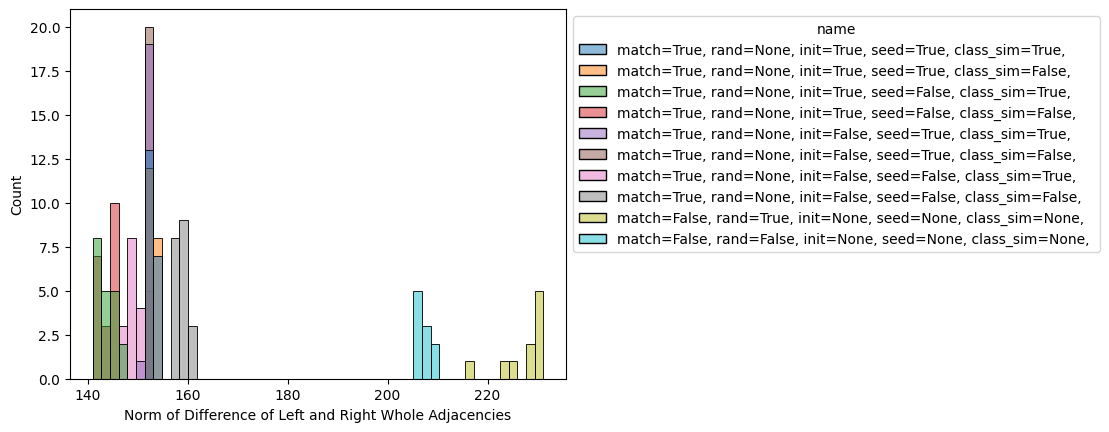

In [573]:
ax_whole = sns.histplot(data=df_whole, x="norm", hue="name")
ax_whole.set_xlabel("Norm of Difference of Left and Right Whole Adjacencies")
sns.move_legend(ax_whole, "upper left", bbox_to_anchor=(1, 1))

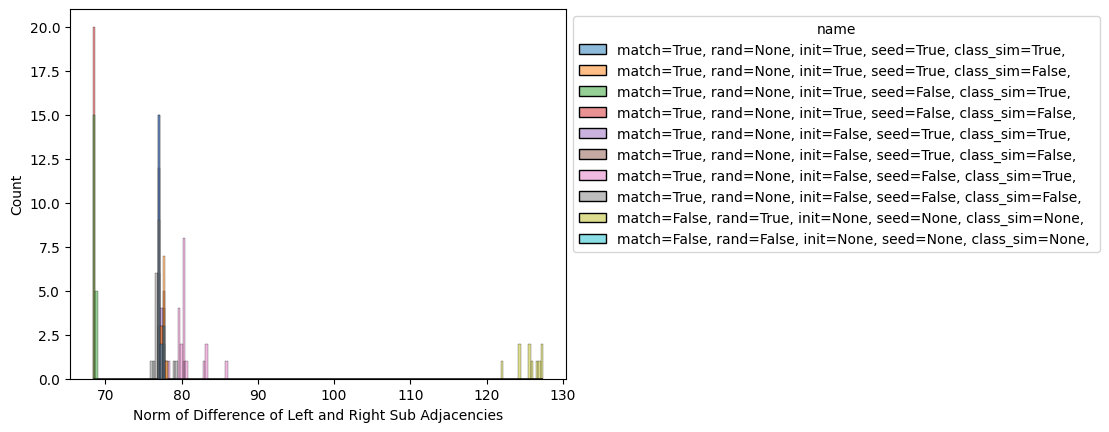

In [ ]:
ax_sub = sns.histplot(data=df_sub, x="norm", hue="name")
ax_sub.set_xlabel("Norm of Difference of Left and Right Sub Adjacencies")
sns.move_legend(ax_sub, "upper left", bbox_to_anchor=(1, 1))

In [574]:
whole_values = init_skids_and_adjs_v2(type="whole")
whole_left_adj = whole_values["left_adj"]
whole_right_adj = whole_values["right_adj"]
whole_left_skids_in_pairs = whole_values["left_skids_in_pairs"]
whole_left_skids_to_match = whole_values["left_skids_to_match"]
whole_right_skids_to_match = whole_values["right_skids_to_match"]
num_pairs = whole_values["num_pairs"]
whole_class_sim = whole_values["class_sim_mat"]

In [ ]:
partial_match_test = np.stack((np.arange(whole_values["num_pairs"]), np.arange(whole_values["num_pairs"]))).T
max_dim = max(len(whole_left_skids_to_match), len(right_skids_to_match))
init_test = np.eye(max_dim-num_pairs)
init_test_2 = np.eye(max_dim)
S_test = whole_class_sim

In [ ]:
init_test.shape

(712, 712)

In [ ]:
dfs, inds_left, inds_right = match_skid_dims(whole_left_skids_to_match, whole_right_skids_to_match, num_pairs, n_iters)
#print(whole_left_adj_list[0][np.ix_(inds[0], inds[0])].shape)